## HR-analytics (Análise Exploratória de dados)

In [1]:
# importando os módulos

import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from minio import Minio
import datetime

In [2]:
# conectando ao servidor data laKe

client = Minio(
    'localhost:9000',
    access_key = 'minioadmin',
    secret_key = 'minioadmin',
    secure = False
)

## Baixando o DataSet do Data Lake

In [3]:
client.fget_object(
    'processing',
    'employees_dataset.parquet',
    'temp_.parquet',
)
df = pd.read_parquet('temp_.parquet')

In [4]:
df.head()

,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,No
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,No
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,No
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,No
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,No


## Data transformation / cleanning

In [5]:
# posicionando a coluna left - alvo no final

df = df[['department', 'salary', 'mean_work_last_3_months', 'number_projects', 'satisfaction_level', 'last_evaluation', 
        'time_in_company', 'work_accident', 'left']]

In [6]:
df.head()

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
0,sales,low,266.000000,2.0,38.0,53.0,3.0,No,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,No,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,No,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,No,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,No,1.0


In [7]:
# missing values

df.isnull().sum()

department                 1
salary                     1
mean_work_last_3_months    0
number_projects            1
satisfaction_level         1
last_evaluation            1
time_in_company            1
work_accident              1
left                       1
dtype: int64

In [8]:
df.shape

(15000, 9)

In [9]:
# dropando missings

df.dropna(axis = 0, inplace = True)

In [10]:
df.isnull().sum()

department                 0
salary                     0
mean_work_last_3_months    0
number_projects            0
satisfaction_level         0
last_evaluation            0
time_in_company            0
work_accident              0
left                       0
dtype: int64

In [11]:
# verificando o tipo dos dados

df.dtypes

department                  object
salary                      object
mean_work_last_3_months    float64
number_projects            float64
satisfaction_level         float64
last_evaluation            float64
time_in_company            float64
work_accident               object
left                       float64
dtype: object

In [12]:
# aplicando filtro

df[df['work_accident'] == 'Yes']

,department,salary,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident,left
18,sales,low,277.333333,2.0,45.0,51.0,3.0,Yes,1.0
68,product_mng,medium,289.333333,5.0,76.0,86.0,5.0,Yes,1.0
120,technical,low,273.666667,4.0,14.0,62.0,4.0,Yes,1.0
123,support,low,276.666667,6.0,11.0,84.0,5.0,Yes,1.0
136,technical,low,271.666667,6.0,10.0,84.0,4.0,Yes,1.0
...,...,...,...,...,...,...,...,...,...
14940,marketing,medium,268.333333,5.0,10.0,78.0,4.0,Yes,1.0
14945,sales,medium,279.666667,4.0,14.0,75.0,5.0,Yes,1.0
14949,hr,medium,278.666667,2.0,42.0,57.0,3.0,Yes,1.0
14989,RandD,medium,304.000000,2.0,43.0,57.0,3.0,Yes,1.0


In [13]:
# renomeando os atributos muito grandes

df = df.rename(columns = {'mean_work_last_3_months' : 'monthlyHours', 
                          'number_projects' : 'projectsCounts', 
                          'satisfaction_level' : 'satisfactionLevel', 
                          'last_evaluation': 'evaluation', 
                          'time_in_company' : 'yearsAtCompany', 
                          'work_accident' : 'workAccident', 
                          'left' : 'turnover'})

In [14]:
df.head()

,department,salary,monthlyHours,projectsCounts,satisfactionLevel,evaluation,yearsAtCompany,workAccident,turnover
0,sales,low,266.000000,2.0,38.0,53.0,3.0,No,1.0
1,sales,medium,252.000000,5.0,80.0,86.0,6.0,No,1.0
2,sales,medium,289.666667,7.0,11.0,88.0,4.0,No,1.0
3,sales,low,275.666667,5.0,72.0,87.0,5.0,No,1.0
4,sales,low,292.333333,2.0,37.0,52.0,3.0,No,1.0


## Análise Exploratória dos dados

### Análise descritiva dos dados

In [15]:
# taxa de turnnover

turnover_rate = df.turnover.value_counts() / len(df)
turnover_rate

0.0    0.761917
1.0    0.238083
Name: turnover, dtype: float64

**Percebemos que os dados estão desbalanceados.**

In [16]:
# describe

df.describe()

,monthlyHours,projectsCounts,satisfactionLevel,evaluation,yearsAtCompany,turnover
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,276.021490,3.803054,61.283352,71.610174,3.498233,0.238083
std,10.048839,1.232592,24.863065,17.116911,1.460136,0.425924
min,232.333333,2.000000,9.000000,36.000000,2.000000,0.000000
25%,269.333333,3.000000,44.000000,56.000000,3.000000,0.000000
50%,276.000000,4.000000,64.000000,72.000000,3.000000,0.000000
75%,282.666667,5.000000,82.000000,87.000000,4.000000,0.000000
max,321.333333,7.000000,100.000000,100.000000,10.000000,1.000000


In [17]:
# Overwiew estatístico

turnover_summary = df.groupby('turnover')
turnover_summary.mean()

,monthlyHours,projectsCounts,satisfactionLevel,evaluation,yearsAtCompany
turnover,,,,,
0.0,276.005775,3.793227,64.888869,71.585054,3.401208
1.0,276.071782,3.834500,49.744889,71.690563,3.808737


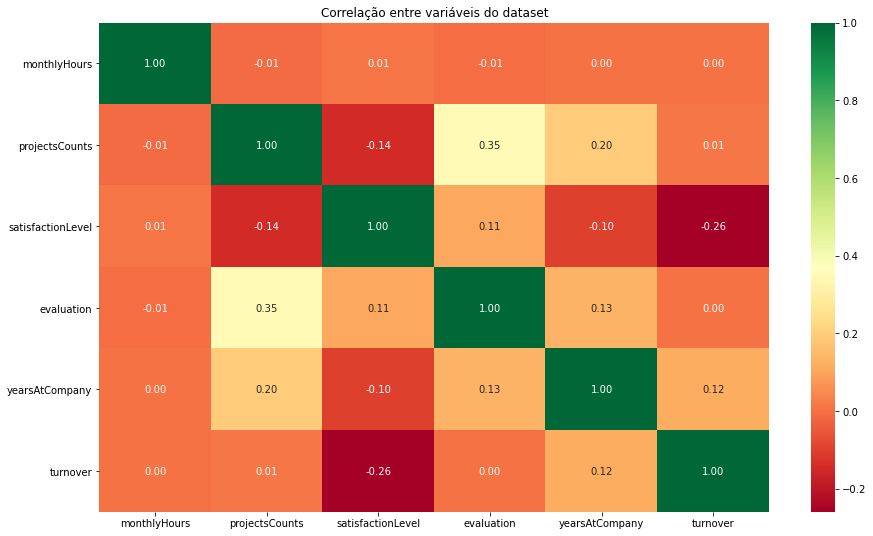

In [18]:
# Análise de correlação

def plot_corr(df):
    plt.figure(figsize=(15, 9))
    corrmat = df.corr()
    top_corr = corrmat.index
    sns.heatmap(df[top_corr].corr(),
            annot = True,
            fmt = '.2f',
            cmap='RdYlGn')
    plt.title('Correlação entre variáveis do dataset')
    plt.show()

    
plot_corr(df)

**Insights:**

**Existe uma correlação moderada positiva entre 'evaluation' vs 'projectsCounts'.**

**Existe uma correlação moderada negativa entre 'turnover' vs 'satisfactionLevel'.**

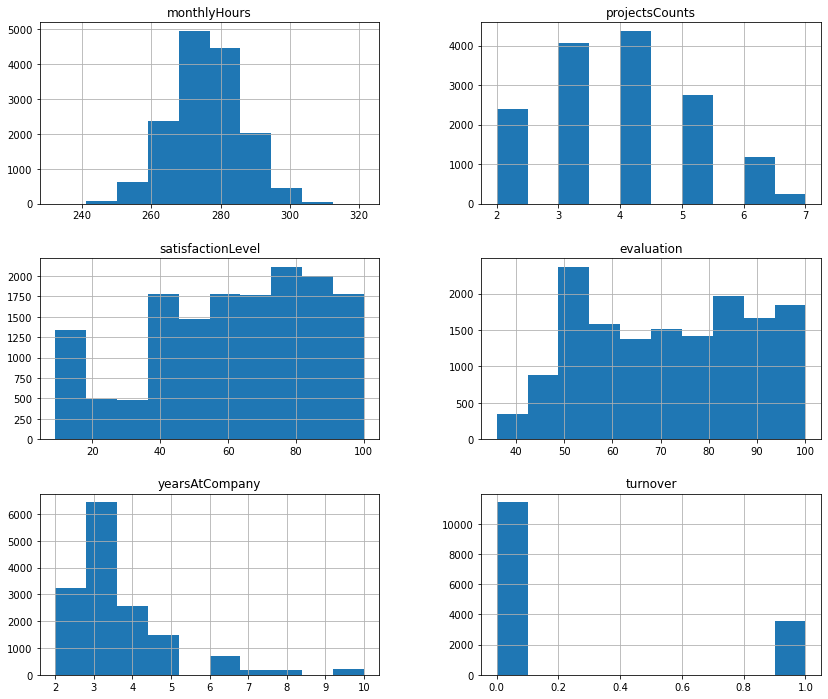

In [19]:
# Distribuição das variáveis - Análise univariada

# Histograma Univariado

df.hist(figsize=(14,12))
plt.show()

**Insights:**

**monthlyHours:** A quantidade média de horas trabalhadas está distribuida em torno de 276 horas (distribuição normal).

**satisfactionLevel:** Existe um pico de colaboradores com baixa satisfação, mas a maioria da satisfação está entre 60 e 100.

**evaluation:** Existe um pico de colaboradores com baixa avaliação, menor que 60 e uma concentração de altas, maior que 80.(bimodal)

C:\Users\abner\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


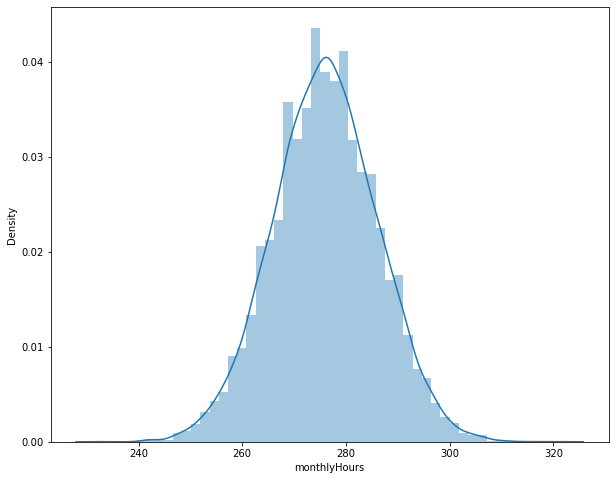

In [20]:
# distribuição da média de horas

# Gráfico de densidade

plt.figure(figsize=(10,8))
sns.distplot(df['monthlyHours'])

plt.show()

**Aparentemente podemos idetinficar que a variável 'monthlyHours' segue uma distribuição normal (gaussiana).**

In [21]:
# aplicando o teste qui-quadrado para normalidade n >= 5000
from scipy.stats import normaltest

stat, p = normaltest(df['monthlyHours'])
print('Estatística: %.10f, p-valor: %.10f' %(stat, p))
if(p <= 0.05):
    print('Distribuição não normal')
else:
    print('É uma distribuição normal!')

Estatística: 0.8431298285, p-valor: 0.6560194020
É uma distribuição normal!


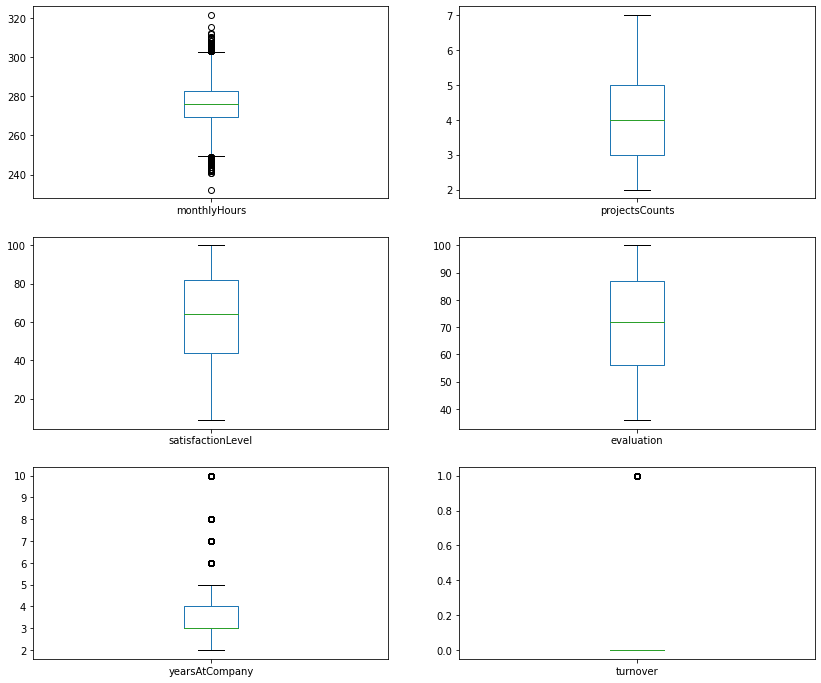

In [22]:
# Análise com box plot, ajuda na identificação de OUTLIERS 

df.plot(kind = 'box', subplots = True, layout= (3,2), figsize=(14,12))
plt.show()

**Insights:**
    
A variável **monthlyHours** apresenta uma concentração maior de OUTLIERs abaixo do limite inferior e acima do limite superior.

## Análise de variáveis categóricas

**Análise univariada**

Permite identificar qual o impacto de cada variável preditora na variável alvo (turnover).

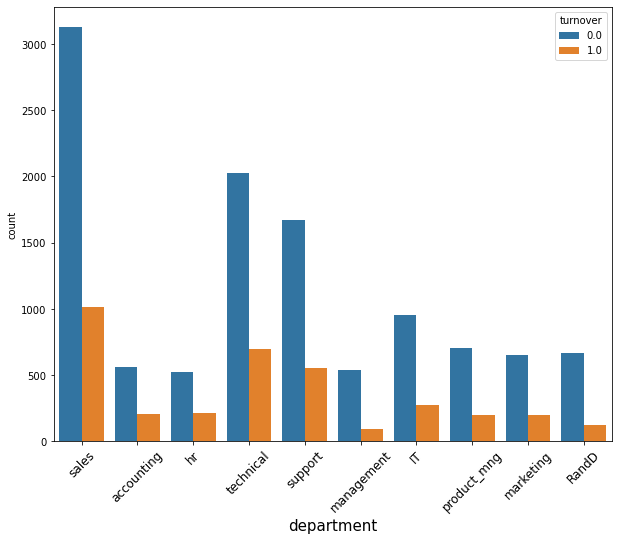

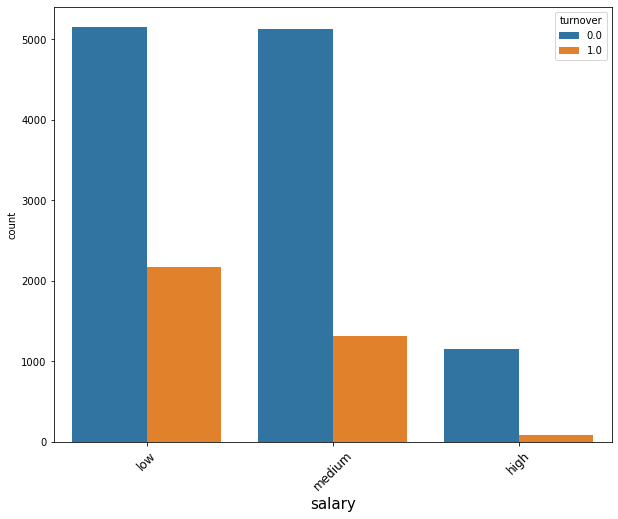

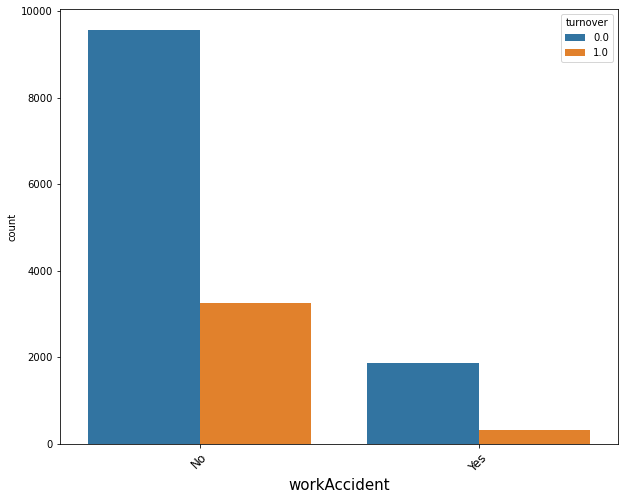

In [23]:
# gerando os gráficos univariados

for i, plot in enumerate(df[['department', 'salary', 'workAccident']]):
    plt.figure(i, figsize=(10,8))
    plt.xticks(rotation=45, fontsize=12)
    plt.xlabel(plot, fontsize=15)
    sns.countplot(data= df, x=plot, hue='turnover')

**Insights:**
    
**department:** Os departamentos de **venda**, **técnico** e o de **suporte** têm uma maior taxa de turnover. O departamento de **management** apresenta a menor taxa de turnover.

**salary:** Os salários **low e medium** apresentam as maiores taxas de turnover, enquanto o salário **high** apresenta uma menor taxa de turnover.

**workAccident:** O número de pessoas que não sofreram acidentes e mesmo assim sairam da empresa é maior do que o número de pessoas acidentadas que deixaram a empresa.

## Análise envolvendo outras variáveis

**A partir das analises feitas acima podemos identificar outros padrões e comportamentos.**

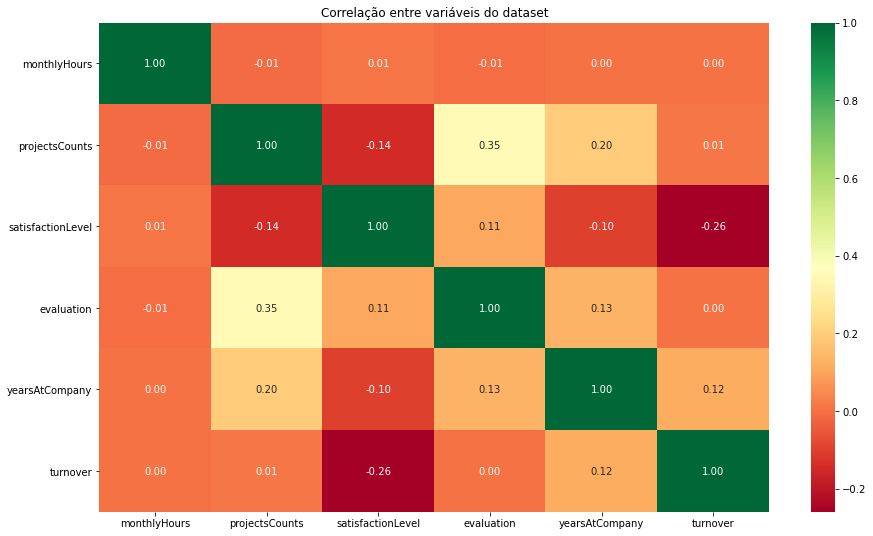

In [24]:
# Análise de correlação novamente

def plot_corr(df):
    plt.figure(figsize=(15, 9))
    corrmat = df.corr()
    top_corr = corrmat.index
    sns.heatmap(df[top_corr].corr(),
            annot = True,
            fmt = '.2f',
            cmap='RdYlGn')
    plt.title('Correlação entre variáveis do dataset')
    plt.show()

    
plot_corr(df)

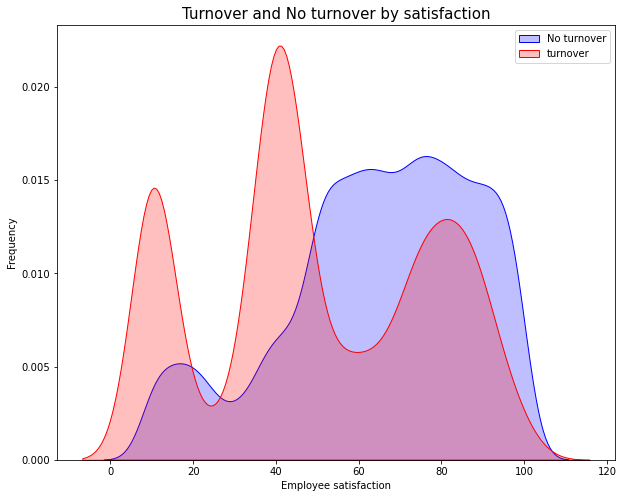

In [25]:
## Turnover em relação ao nível de satisfação

plt.figure(figsize=(10,8))
mon = sns.kdeplot(df.satisfactionLevel[(df['turnover'] == 0)], color='blue', shade=True)
mon = sns.kdeplot(df.satisfactionLevel[(df['turnover'] == 1)], color='red', shade=True)
mon.legend(['No turnover', 'turnover'], loc='upper right')
mon.set_ylabel('Frequency')
mon.set_xlabel('Employee satisfaction')
mon.set_title('Turnover and No turnover by satisfaction', fontsize=15)
plt.show();

**Insights e perguntas Turnover vs satisfaction:**
    
**Colaboradores com satisfação entre 60 e 90 deixam menos a empresa.**

**Porque colaboradores com satisfação baixa (0 a 20) e (20 a 50) deixam a empresa?(experiência ruim, salário, falta de crescimento, ambiênte).**

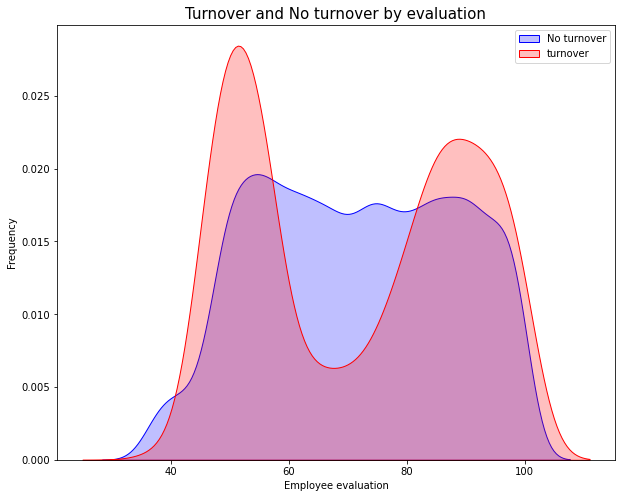

In [26]:
## Turnover em relação ao nível de avaliação

plt.figure(figsize=(10,8))
mon = sns.kdeplot(df.evaluation[(df['turnover'] == 0)], color='blue', shade=True)
mon = sns.kdeplot(df.evaluation[(df['turnover'] == 1)], color='red', shade=True)
mon.legend(['No turnover', 'turnover'], loc='upper right')
mon.set_ylabel('Frequency')
mon.set_xlabel('Employee evaluation')
mon.set_title('Turnover and No turnover by evaluation', fontsize=15)
plt.show();

**Insights e perguntas Turnover vs evaluation:**

**Colaboradores com notas medianas (entre 60 e 80), tendem a permanecer na empresa.**

**Porque alguns colaboradores deixaram a empresa mesmo recebendo uma avaliação alta pela empresa?** **O colaborador está envolvido em um número muito grande de projetos(desgastado fisico / mentalmente)?**

**Porque colaboradores com baixa avaliação também deixam a empresa?(falta de motivação, desistem da carreira).**

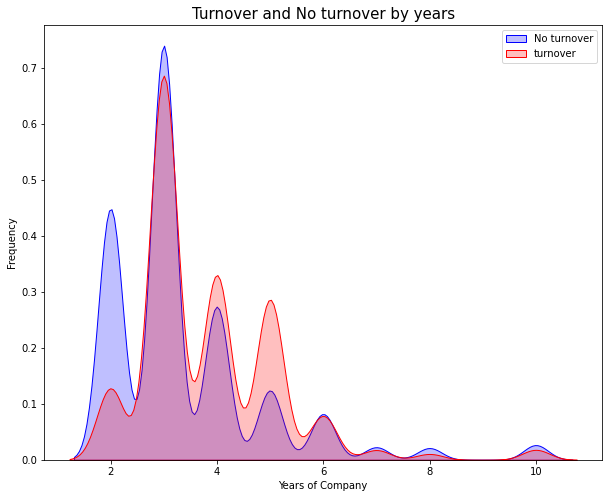

In [27]:
# anos de companhia e turnover

plt.figure(figsize=(10,8))
mon = sns.kdeplot(df.yearsAtCompany[(df['turnover'] == 0)], color='blue', shade=True)
mon = sns.kdeplot(df.yearsAtCompany[(df['turnover'] == 1)], color='red', shade=True)
mon.legend(['No turnover', 'turnover'], loc='upper right')
mon.set_ylabel('Frequency')
mon.set_xlabel('Years of Company')
mon.set_title('Turnover and No turnover by years', fontsize=15)
plt.show();

**Insights por anos de empresa e turnover**

**Colaboradores com até 2 anos de empresa tedem a permanecer nela.**

**Porque colaboradores que tem de 4 a 6 anos tendem a deixar a empresa?(devido ao número grande de projetos).**

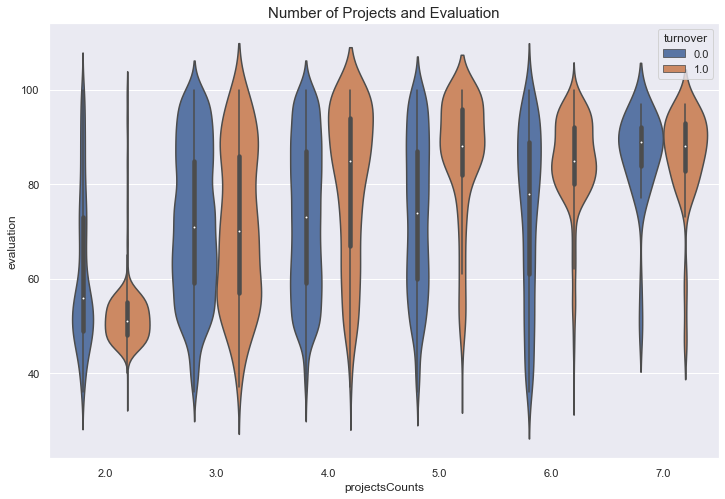

In [28]:
## Avaliação vs number of projects

# setando o grid
sns.set_theme()

plt.figure(figsize=(12,8))
sns.violinplot(x='projectsCounts', y='evaluation', data = df, hue='turnover')
plt.title('Number of Projects and Evaluation', fontsize=15)
plt.show()

**Insights e perguntas Number of projects vs evaluation:**
    
**Pessoas que recebem um aumento muito grande na avaliação tendem a deixar a empresa.**

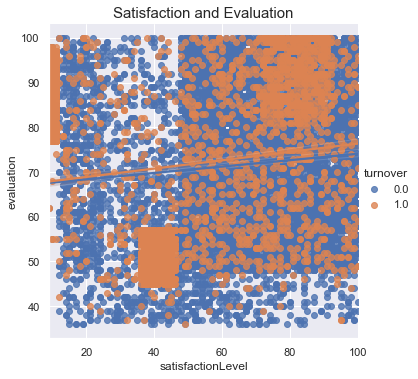

In [29]:
## Análise de clusters lmplot

sns.lmplot(data = df, x='satisfactionLevel', y='evaluation', fit_reg=True, hue ='turnover')
plt.title('Satisfaction and Evaluation', fontsize=15)
plt.show()

**Insights e perguntas Turnover by satisfaction vs evaluation:**

**Grupos identificados de turnover:**

**Cluster 1 (Trabalhadores insatisfeitos, mas com boa avaliação):**
* O que faz um colaborador deixar a empresa mesmo sendo um bom trabalhador?
* Será que eles estão insatisfeitos (salário, ambiente de trabalho, projetos)?

**Cluster 2 (Trabalhadores insatisfeitos e com baixa avaliação):**
* Será que o fato de ser mal avaliado enfluencia a saída da empresa?
* Este grupo possui baixo desempenho / baixa disciplina?

**Cluster 3 (Trabalhadores bastante satisfeitos e bem avalidados):**
* Porque os melhores colaboradores deixam a empresa? (falta de insentivo, falta oportunidades)
* Será que encontraram outras oportunidades?

### Rodando um algoritmo de clusterização

**Vamos salvar um algoritmo de clusterização para fazer um estudo mais detalhado destes grupos.**

In [30]:
# iniciando K means

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=2)

In [31]:
# dividindo turnover por evaluation vs satisfaction

turnover_df = df[df['turnover']==1][['satisfactionLevel','evaluation']]
turnover_df.head()

,satisfactionLevel,evaluation
0,38.0,53.0
1,80.0,86.0
2,11.0,88.0
3,72.0,87.0
4,37.0,52.0


In [32]:
# computando os clusters nestes grupo

kmeans.fit(turnover_df)

KMeans(n_clusters=3, random_state=2)

In [33]:
# definindo as cores para os clusters

kmeans_colors = ['green' if c ==0 else 'red' if c ==1 else 'blue' for c in kmeans.labels_]

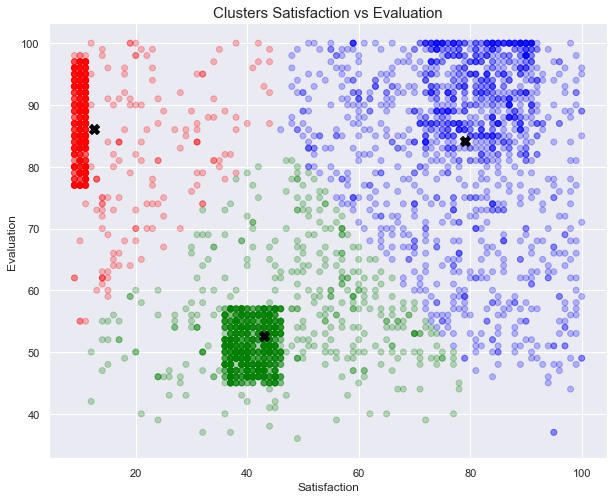

In [39]:
# plotando os clusters

plt.figure(figsize=(10,8))
plt.scatter(data = turnover_df, x='satisfactionLevel', y='evaluation', alpha=0.25, color = kmeans_colors)
plt.xlabel('Satisfaction')
plt.ylabel('Evaluation')

# centróides
plt.scatter(x=kmeans.cluster_centers_[:,0], # centróide coluna 1
           y = kmeans.cluster_centers_[:,1], # centróide coluna 2
           color = 'black',
           marker = 'X',
           s = 100)

plt.title('Clusters Satisfaction vs Evaluation', fontsize=15)
plt.show()

**Cluster 1 - Vermelho (Trabalhadores insatisfeitos, mas com boa avaliação):**

**Cluster 2 - Verde (Trabalhadores insatisfeitos e com baixa avaliação):**

**Cluster 3 - Azul (Trabalhadores bastante satisfeitos e bem avalidados):**

In [41]:
# fazendo o dump do modelo

import joblib

joblib.dump(kmeans, 'cluster.joblib')

['cluster.joblib']

## Salvando o modelo no Data Lake

In [42]:
client.fput_object(
    'curated',
    'cluster.joblib',
    'cluster.joblib'
)